### In this nb we will seek to make the analysis in Exploratory2 more robust by doing a more thorough cleaning of the time series data to remove influence of seasonality and changing variance. We will also compare our distributed lag model with the impulse response from a VAR model and an ARDL model.

In [1]:
from utils import *

<AxesSubplot:xlabel='date'>

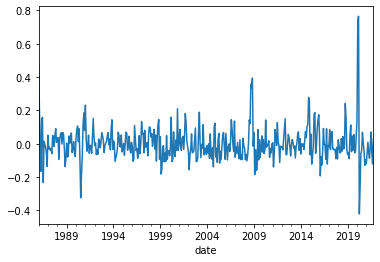

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True)['spot'].pct_change().dropna()
wti.plot()

In [3]:
av = wti.groupby(wti.index.year).std()
print(len(av))

36


In [4]:
wti_av = wti.index.map(lambda x: av.loc[x.year])
print(len(wti_av) == len(wti))

True


In [5]:
wti = wti/wti_av

<AxesSubplot:xlabel='date'>

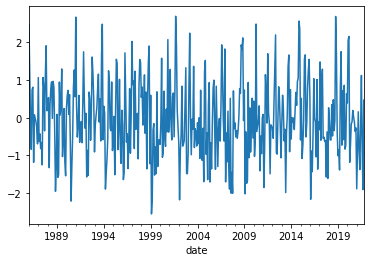

In [6]:
wti.plot()

<AxesSubplot:xlabel='date'>

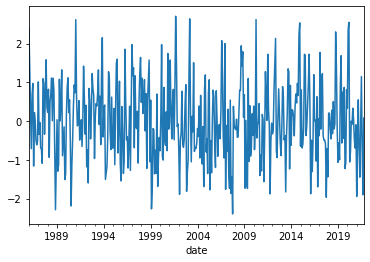

In [7]:
ma = wti.groupby(wti.index.month).mean()
wti_ma = wti.index.map(lambda x: ma.loc[x.month])
wti = wti - wti_ma
wti.plot()

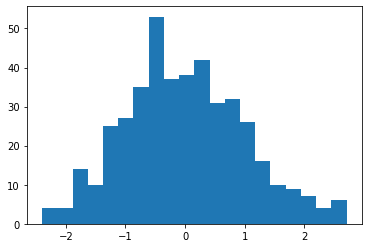

In [8]:
plt.hist(wti, bins=20)
plt.show()

<AxesSubplot:xlabel='date'>

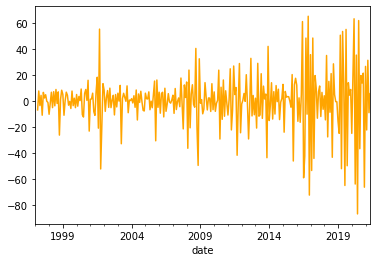

In [9]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True)
epu['MA2'] = epu.GEPU_current.rolling(2).mean()
epu_shock = (epu.GEPU_current - epu.MA2).diff()
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

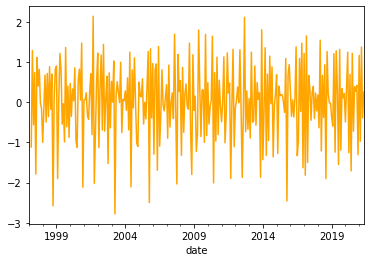

In [10]:
av1 = epu_shock.groupby(epu_shock.index.year).std()
epu_av = epu_shock.index.map(lambda x: av1.loc[x.year])
epu_shock = epu_shock/epu_av
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

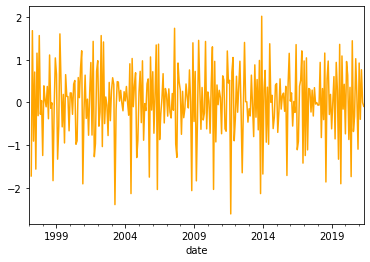

In [11]:
ma1 = epu_shock.groupby(epu_shock.index.month).mean()
epu_ma = epu_shock.index.map(lambda x: ma1.loc[x.month])
epu_shock = epu_shock - epu_ma
epu_shock.plot(color='orange')

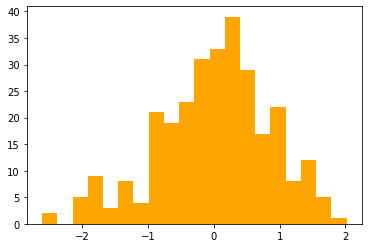

In [12]:
plt.hist(epu_shock, bins=20, color='orange')
plt.show()

In [13]:
df = pd.DataFrame(wti.rename('wti')).join(epu_shock.rename('epu_shock')).dropna()
df.head()

,wti,epu_shock
date,,
2021-05-01,-1.447284,-0.091700
2021-04-01,-0.708349,0.000687
2021-03-01,0.548346,0.765670
2021-02-01,-0.545331,-0.396248
2021-01-01,-1.947965,0.922549


In [14]:
model1 = dl('wti', 'epu_shock', df)
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.998
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0212
Time:                        13:13:48   Log-Likelihood:                -390.90
No. Observations:                 279   AIC:                             809.8
Df Residuals:                     265   BIC:                             860.6
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0083      0.060     -0.137      0.891      -0.127       0.110
epu_shock-lag0     -0.1605      0.092     -1.745      0.082      -0.342       0.021
epu_shock-lag1     -0.3860      0.125     -3.093      0.002      -0.632      -0.140
epu_shock-lag2     -0.4965      0.155     -3.208      0.002      -0.801      -0.192
epu_shock-lag3     -0.3723      0.167     -2.232      0.026      -0.701      -0.044
epu_shock-lag4     -0.2656      0.180     -1.476      0.141      -0.620       0.089
epu_shock-lag5      0.0360      0.183      0.197      0.844      -0.324       0.396
epu_shock-lag6      0.0313      0.189      0.165      0.869      -0.342       0.404
epu_shock-lag7      0.1539      0.187      0.822      0.412      -0.215       0.522
epu_shock-lag8      0.0886      0.176      0.503      0.616      -0.259       0.436
epu_shock-lag9     -0.0502      0.171     -0.294      0.769      -0.387       0.286
epu_shock-lag10     0.0722      0.150      0.482      0.630      -0.223       0.367
epu_shock-lag11     0.0218      0.128      0.170      0.865      -0.230       0.273
epu_shock-lag12  4.221e-05      0.094      0.000      1.000      -0.185       0.185
==============================================================================
Omnibus:                        2.664   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                2.292
Skew:                           0.117   Prob(JB):                        0.318
Kurtosis:                       2.623   Cond. No.                         8.96
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

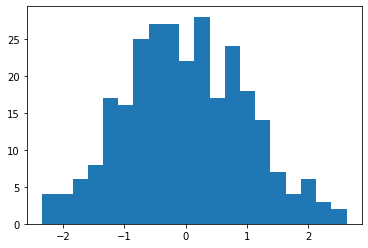

In [15]:
plt.hist(model1.resid, bins=20)
plt.show()

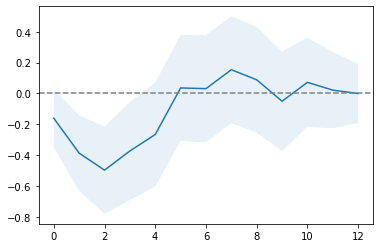

In [16]:
plt.plot(model1.params[1:].reset_index(drop=True))
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

### VAR

In [17]:
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

In [18]:
for l in range(1, 15):
    res = pearsonr(df['wti'].iloc[l:], df['epu_shock'].iloc[:-l])
    print(f'Lag {l}: {res}')

Lag 1: (-0.026301636847725855, 0.6555658485481355)
Lag 2: (-0.1299220788639569, 0.027211400997351975)
Lag 3: (0.005363777463174894, 0.9277857170707577)
Lag 4: (-0.07720205784965568, 0.19219091922197967)
Lag 5: (0.13460700277332238, 0.022797391625006887)
Lag 6: (-0.039099717120016086, 0.5109046573339044)
Lag 7: (0.06272806575175702, 0.29211751282770493)
Lag 8: (0.017292787415588387, 0.772088742089027)
Lag 9: (-0.1023808062381602, 0.08613607609563176)
Lag 10: (0.08440486011296752, 0.15821642461001414)
Lag 11: (-0.02921457977746522, 0.6264210043675037)
Lag 12: (0.0037805590636103906, 0.9498743995529004)
Lag 13: (0.023189403495827682, 0.700271289257842)
Lag 14: (0.01147555587217938, 0.8492042017828147)


In [19]:
model2 = VAR(df.dropna()).fit(maxlags=5)
model2.summary()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Dec, 2021
Time:                     13:13:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.474912
Nobs:                     286.000    HQIC:                 -0.643417
Log likelihood:          -681.505    FPE:                   0.469510
AIC:                    -0.756142    Det(Omega_mle):        0.435375
--------------------------------------------------------------------
Results for equation wti
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.005292         0.058922           -0.090           0.928
L1.wti               0.137229         0.060503            2.268           0.023
L1.epu_shock        -0.225213         0.089714           -2.510   

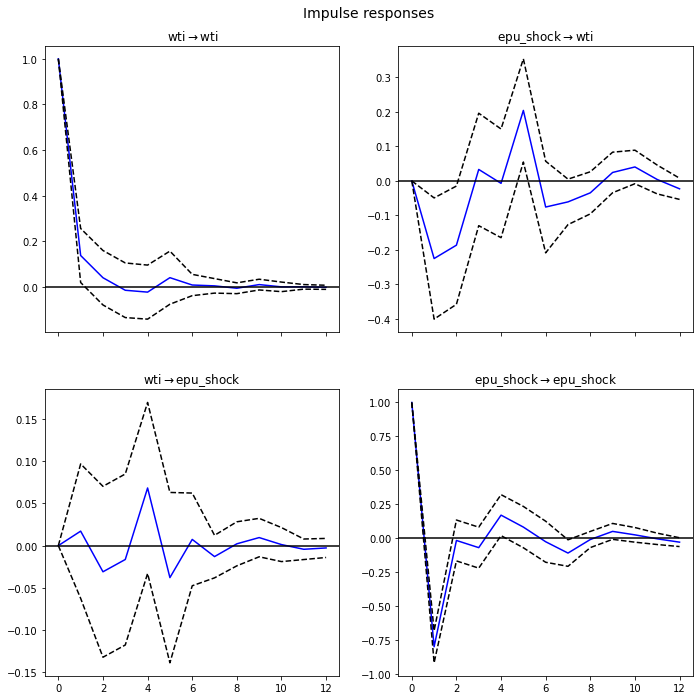

In [20]:
s = model2.irf(12).plot()

### ARDL

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
gct = grangercausalitytests(pd.DataFrame(epu_shock.rename('epu_shock')).join(wti.rename('wti')).dropna(), 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0958  , p=0.7571  , df_denom=287, df_num=1
ssr based chi2 test:   chi2=0.0968  , p=0.7557  , df=1
likelihood ratio test: chi2=0.0968  , p=0.7557  , df=1
parameter F test:         F=0.0958  , p=0.7571  , df_denom=287, df_num=1


In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


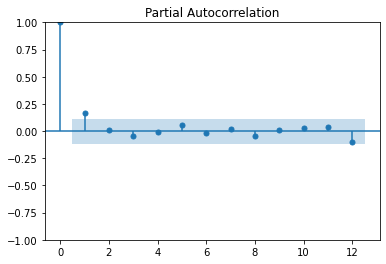

In [24]:
s = plot_pacf(df['wti'], lags=12, alpha=.05)

In [25]:
model3 = ardl('wti', 'epu_shock', df, lags=[1,12])

In [26]:
model3.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.349
Date:                Thu, 30 Dec 2021   Prob (F-statistic):            0.00443
Time:                        13:13:50   Log-Likelihood:                -387.57
No. Observations:                 279   AIC:                             805.1
Df Residuals:                     264   BIC:                             859.6
Df Model:                          14                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0065      0.060     -0.109      0.913      -0.124       0.111
wti-lag1            0.1537      0.062      2.462      0.014       0.031       0.277
epu_shock-lag0     -0.1653      0.091     -1.825      0.069      -0.344       0.013
epu_shock-lag1     -0.3664      0.124     -2.963      0.003      -0.610      -0.123
epu_shock-lag2     -0.4401      0.157     -2.796      0.006      -0.750      -0.130
epu_shock-lag3     -0.2998      0.169     -1.772      0.077      -0.633       0.033
epu_shock-lag4     -0.2105      0.176     -1.196      0.233      -0.557       0.136
epu_shock-lag5      0.0754      0.179      0.421      0.674      -0.277       0.428
epu_shock-lag6      0.0267      0.185      0.144      0.886      -0.338       0.392
epu_shock-lag7      0.1504      0.180      0.833      0.405      -0.205       0.506
epu_shock-lag8      0.0670      0.173      0.387      0.699      -0.274       0.409
epu_shock-lag9     -0.0625      0.166     -0.376      0.708      -0.390       0.265
epu_shock-lag10     0.0808      0.149      0.542      0.588      -0.212       0.374
epu_shock-lag11     0.0105      0.125      0.084      0.933      -0.236       0.257
epu_shock-lag12    -0.0031      0.093     -0.033      0.974      -0.186       0.180
==============================================================================
Omnibus:                        2.758   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.540
Skew:                           0.157   Prob(JB):                        0.281
Kurtosis:                       2.655   Cond. No.                         9.02
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

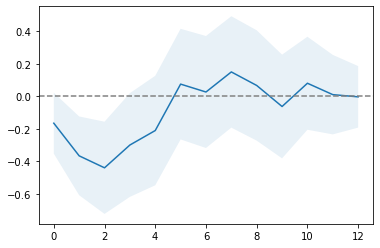

In [27]:
plt.plot(model3.params[2:].reset_index(drop=True))
plt.fill_between([*range(13)], model3.conf_int()[0][2:], model3.conf_int()[1][2:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

Given that VAR model is dependent on construction, it may be better to use the single equation models. ARDL has a higher adjusted R^2 than DL, which implies it is better at explaining variations in the data.